<a href="https://colab.research.google.com/github/TsukeBarrel/ocr_task/blob/main/ocr_task_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/TsukeBarrel/ocr_task.git

Cloning into 'ocr_task'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 1), reused 11 (delta 1), pack-reused 0
Receiving objects: 100% (14/14), 756.51 KiB | 2.76 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
%cd '/content/ocr_task/data'
!pwd

/content/ocr_task/data
/content/ocr_task/data


In [3]:
!pip install easyocr

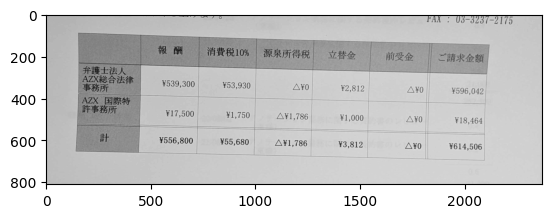

In [4]:
"""
ライブラリ読み込み、画像読み込み
"""
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2

get_ipython().run_line_magic('matplotlib', 'inline')

def show_img(img):
    plt.imshow(img)

def show_gray_img(img):
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)


image = cv2.imread('./表抽出課題.png')
if image is None:
    print("none")
else:
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    show_gray_img(image_gray)

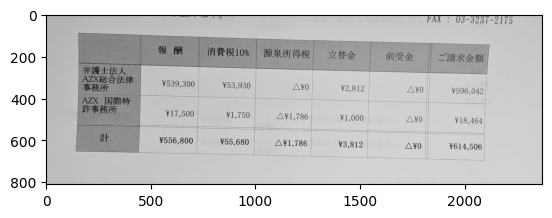

In [5]:
#ノイズ低減
denoised_image = cv2.fastNlMeansDenoising(image_gray)
show_gray_img(denoised_image)

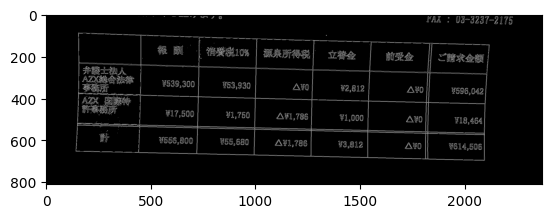

In [6]:
#Canny法でエッジ抽出
threshold1 = 100
threshold2 = 100
edges = cv2.Canny(denoised_image, threshold1, threshold2)

show_gray_img(edges)

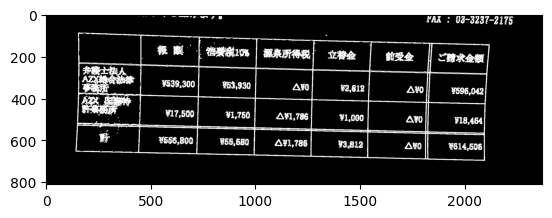

In [7]:
#膨張処理で隙間を埋める
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
dilated_image = cv2.dilate(edges,kernel,iterations = 1)
show_gray_img(dilated_image)

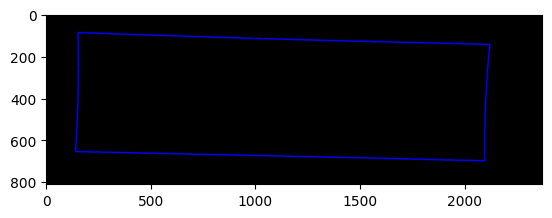

In [8]:
"""
一番外側の輪郭を抽出し、affine変換でROIを抜き出す
"""

#切り取る領域を視覚化するために画像と同サイズの空のnumpy配列を作成
y_size, x_size = denoised_image.shape
if x_size < y_size:
  short_len = x_size
else:
  short_len = y_size

empty_img = np.zeros((y_size, x_size, 3), np.uint8)


#最外郭の輪郭抽出
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
max_cnt = max(contours, key=lambda x: cv2.contourArea(x))
cv2.drawContours(empty_img, max_cnt, -1, color=(0, 0, 255), thickness=5)

show_img(empty_img)

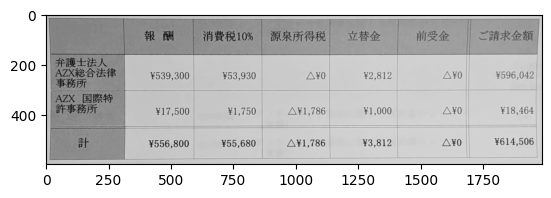

In [9]:
"""
抽出した輪郭からサイズと傾きを求めてaffine1変換でROIを切り取り
抽出する際に上下にバッファーを追加して、切り取る領域を拡張している
"""
rect = cv2.minAreaRect(max_cnt)
center, size, angle = rect
width, height = size
width += 20
height += 30
size = (width, height)
center = tuple(map(int, center))
size = tuple(map(int, size))
box = cv2.boxPoints(rect)
box = np.int0(box)

M = cv2.getRotationMatrix2D(center, angle, 1)
rotated_img = cv2.warpAffine(denoised_image, M, (x_size, y_size))
cropped_img = cv2.getRectSubPix(rotated_img, size, center)

show_gray_img(cropped_img)

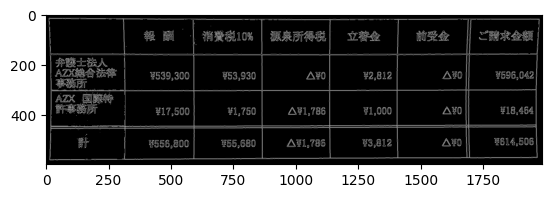

In [10]:
"""
切り取った画像に対して、キャニー法でエッジを抽出
"""
threshold1 = 100
threshold2 = 100
cropped_edges = cv2.Canny(cropped_img, threshold1, threshold2)

show_gray_img(cropped_edges)

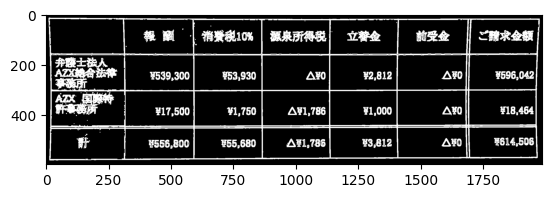

In [11]:
#抽出したエッジに膨張処理
dilated_cropped_image = cv2.dilate(cropped_edges,kernel,iterations = 1)
show_gray_img(dilated_cropped_image)

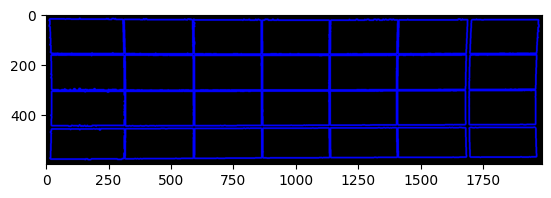

In [12]:
"""
今回は、輪郭抽出ですべてのセルを個別に認識＆抽出
それぞれのセルの座標データを使って並び替えることで、CSVの行列の識別と個々のROIの認識を一本化する
"""
#切り取る領域を可視化するためにROIと同サイズの空のnumpy配列を作成
y_size, x_size = cropped_img.shape
if x_size < y_size:
  short_len = x_size
else:
  short_len = y_size

empty_cropped_img = np.zeros((y_size, x_size, 3), np.uint8)


#輪郭抽出
contours, hierarchy = cv2.findContours(dilated_cropped_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = list(filter(lambda x:  50000 > cv2.contourArea(x) > 20000, contours))
cv2.drawContours(empty_cropped_img, contours, -1, color=(0, 0, 255), thickness=5)

show_img(empty_cropped_img)

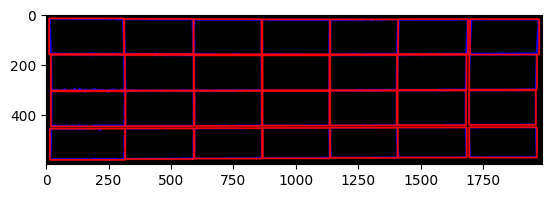

In [13]:
"""
個々の輪郭に外接する四角形を描画、それぞれ四角形の座標を取得
座標をリストに結合することで、セルの並び替えが可能になる
"""

rectangles = []

for cnt in contours:
  rect = cv2.boundingRect(cnt)
  rectangles.append(rect)
  x0, y0, w, h = rect
  rect_empty_img = cv2.rectangle(empty_cropped_img,(x0, y0), (x0+w, y0+h), (255,0,0),5)

#y軸方向にソート。pandasを用いてCSV化するため、行ごとにセルをまとめる下準備
rectangles.sort(reverse=False, key=lambda x:x[1])

show_img(rect_empty_img)

In [14]:
"""
deepcopyでオリジナルとは別アイテムとして、行ごとのリストを作成
行ごとのリストをさらにリスト化してイテラブルなアイテムとする
"""


row_0 = copy.deepcopy(rectangles[0:7])
row_1 = copy.deepcopy(rectangles[7:14])
row_2 = copy.deepcopy(rectangles[14:21])
row_3 = copy.deepcopy(rectangles[21:28])

table_list = [row_0, row_1, row_2, row_3]

In [15]:
"""
easyocrとpandasを読み込み、easyocrの設定を行う
"""

import easyocr
import pandas as pd

reader = easyocr.Reader(['ja', 'en'])

In [16]:
"""
作成されたセルのリストをfor文で回して、easyocrを適用していく
一番最初のリストを読み込んだ結果を列ラベルとして、pandasのデータフレームを作成する
その後は行リストの一番最初の要素を行ラベルとして、その他の要素をデータフレームに追加していく
"""


tmp_col = []

for y_idx, col in enumerate(table_list):
  col.sort(reverse=False, key=lambda x:x[0])
  if y_idx == 0:
    for x_idx, tmp in enumerate(col):
      if x_idx == 0:
        continue
      else:
        x, y, w, h = tmp
        roi = cropped_img[y:y+h, x:x+w]
        tmp_res = reader.readtext(roi, detail=0)
        tmp_res = ''.join(tmp_res)
        tmp_col.append(tmp_res)
    res_df = pd.DataFrame(columns=[tmp_col])
    tmp_col.clear()

  else:
    for x_idx, tmp in enumerate(col):
      if x_idx == 0:
        x, y, w, h = tmp
        roi = cropped_img[y:y+h, x:x+w]
        tmp_res = reader.readtext(roi, detail=0)
        tmp_res = ''.join(tmp_res)
        tmp_idx = tmp_res
      else:
        x, y, w, h = tmp
        roi = cropped_img[y:y+h, x:x+w]
        tmp_res = reader.readtext(roi, detail=0)
        tmp_res = ''.join(tmp_res)
        tmp_col.append(tmp_res)
    res_df.loc[tmp_idx] = tmp_col
    tmp_col.clear()


  print(res_df)

Empty DataFrame
Columns: [(報 醐,), (消費税10%,), (源泉所得税,), (立替金,), (前受金,), (ご請求金額,)]
Index: []
                      報 醐  消費税10% 源泉所得税     立替金 前受金     ご請求金額
弁護士法人AZx総合法律事務所  平539,300  平3,930     t  42,812   t  4596,042
                      報 醐  消費税10%  源泉所得税     立替金 前受金     ご請求金額
弁護士法人AZx総合法律事務所  平539,300  平3,930      t  42,812   t  4596,042
AZX国際特許事務所        117,500  11,750  1,786   0001し   t   118,464
                      報 醐   消費税10%   源泉所得税     立替金 前受金     ご請求金額
弁護士法人AZx総合法律事務所  平539,300   平3,930       t  42,812   t  4596,042
AZX国際特許事務所        117,500   11,750   1,786   0001し   t   118,464
計                1556,800  155,680  11,786  13,812   t  1614,506


In [17]:
"""
作成されたデータフレームをcsv形式で現在のディレクトリに保存する
"""
res_df.to_csv('./ocr_task_res.csv')